#### Homography is a projective transformation. For a 2d projective transform, after homogenization of coordinates, we get a matrix with 8 unknowns. Hence we need 4 points in each image at minimum to compute the homography between them.
#### The four points will result in 8 equations, using which, we can solve the homography H $$Hx_i = x_i', i \in [1, 4]$$
#### H = $\begin{bmatrix} h_1 & h_2 & h_3 \\ h_4 & h_5 & h_6 \\ h_7 & h_8 & h_9 \end{bmatrix}$, setting one element $h_9 = 1$ leaves us with 8 degrees of freedom.
#### Now, to solve this system of equations
#### A = $\begin{bmatrix} x_1 & y_1 & 1 & 0 & 0 & 0 & -x_1x_1' & -y_1x_1' \\ 0 & 0 & 0 & x_1 & y_1 & 1 & -x_1y_1' & -y_1y_1' \\ \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots \\ x_n & y_n & 1 & 0 & 0 & 0 & -x_nx_n' & -y_nx_n' \\ 0 & 0 & 0 & x_n & y_n & 1 & -x_ny_n' & -y_ny_n' \end{bmatrix}$ h = $\begin{bmatrix} h_1 \\ h_2 \\ h_3 \\ \vdots \\ h_8 \end{bmatrix}$ c = $\begin{bmatrix} x_1' \\ y_1' \\ \vdots \\ x_N' \\ y_N' \end{bmatrix}$

#### In our case, N = 4. Since A is then a square matric, we can solve for $$h = A^{-1}c$$

In [23]:
# Imports
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib as mtplt
import numpy as np
import cv2
import math

## Homography Class

In [28]:
class Homography:
    """
    A class to perform homography operations such as image stitching and scene augmentation.
    """
    def __init__(self):
        """
        Initializes the Homography class with placeholder values.
        """
        pass

    def get_images_scene_augmentation(self):
        """
        Loads and displays two images side by side for scene augmentation. One image is a rotated version of a poster, and the other is a wall image.

        The method uses subplots to display the images and sets the axes off for better visualization.
        """
        # Load images
        self.poster_image = mpimg.imread('HW2_image1.jpg')
        self.poster_image = np.rot90(self.poster_image, 2)
        self.wall_image = mpimg.imread('HW2_image2.jpg')

        # Create subplots with 1 row and 2 columns
        fig, axs = plt.subplots(1, 2, figsize=(10, 5))

        # Display the first image (poster_image)
        axs[0].imshow(self.poster_image, origin='upper')
        axs[0].axis('off')  # Hide axes for the first image
        axs[0].set_title('Poster Image')

        # Display the second image (wall_image)
        axs[1].imshow(self.wall_image, origin='upper')
        axs[1].axis('off')  # Hide axes for the second image
        axs[1].set_title('Wall Image')

        # Show the plot with both images
        plt.show()

    def get_points_for_scene_augmentation(self, num_points):
        """
        Allows manual selection of `num_points` points from the images to compute homographies for image blending.

        Args:
            num_points (int): Number of points to select on both the poster and wall images.

        Notes:
            - Uses matplotlib to interactively select points.
        """
        # To allow an interactive display of images for clicking and manually getting the points.
        mtplt.use('TkAgg')

        # Click points on image1
        plt.imshow(self.poster_image)
        self.poster_points = plt.ginput(num_points)

        # Click points on image2
        plt.imshow(self.wall_image)
        self.wall_points = plt.ginput(num_points)


    def get_images_for_stitching(self, downsampling_factor):
        """
        Loads images for stitching and downsamples them by the given factor.
        Display the images.

        Args:
            downsampling_factor (int): Factor by which to downsample the images for faster processing.

        Notes:
            - Central image is selected based on the middle index of the image list.
            - Images are displayed after loading and downsampling.
        """
        self.images = []

        # TODO(KSorte): Make this less hard coded.
        # self.images.append(cv2.imread('image_stitching_img1.jpeg'))
        # self.images.append(cv2.imread('image_stitching_img2.jpeg'))
        # self.images.append(cv2.imread('image_stitching_img3.jpeg'))

        # self.images.append(cv2.imread('ML_Playground3_1.jpeg'))
        # self.images.append(cv2.imread('ML_Playground3_2.jpeg'))
        # self.images.append(cv2.imread('ML_Playground3_3.jpeg'))

        # self.images.append(cv2.imread('ML_Playground1_1.jpeg'))
        # self.images.append(cv2.imread('ML_Playground1_2.jpeg'))
        # self.images.append(cv2.imread('ML_Playground1_3.jpeg'))
        # self.images.append(cv2.imread('ML_Playground1_4.jpeg'))

        self.images.append(cv2.imread('FisherAve_1.jpeg'))
        self.images.append(cv2.imread('FisherAve_2.jpeg'))
        self.images.append(cv2.imread('FisherAve_3.jpeg'))


        for i in range(len(self.images)):
            new_width = self.images[i].shape[1] // downsampling_factor
            new_height = self.images[i].shape[0] // downsampling_factor
            self.images[i] = cv2.resize(self.images[i], (new_width, new_height), interpolation=cv2.INTER_LINEAR)

            # Convert images to RGB for Matplotlib (OpenCV loads in BGR format)
            self.images[i] = cv2.cvtColor(self.images[i], cv2.COLOR_BGR2RGB)

        # Assign a central image that will not be warped.
        self.central_image_index = len(self.images)//2

        # Plot.
        for image in self.images:
            plt.imshow(image)
            plt.show()

    def place_source_image_into_destination(self, source_image, destination_image, dest_image_points, homography):
        """
        Warp and overlay a source image onto a destination image using a homography.

        Args:
            source_image (np.ndarray): Source image to be warped (BGR format).
            destination_image (np.ndarray): Destination image (BGR format).
            dest_image_points (np.ndarray): Points defining the polygon for masking (shape: (N, 2)).
            homography (np.ndarray): 3x3 homography matrix for perspective transformation.

        Returns:
            np.ndarray: Image with the source warped and overlaid onto the destination.
        """
        # Create an image matrix of size equal to destination and warp the source image into it,
        # using the computed homography.
        warped_image = cv2.warpPerspective(source_image, homography,(destination_image.shape[1],destination_image.shape[0]))

        # Mask the poster image inside the polygon given by the selected points.
        masked_image = cv2.fillPoly(destination_image.copy(), [dest_image_points.astype(int)], 0)

        # # Bitwise or to combine the warped image and the masked image.
        overlayed_image = cv2.bitwise_or(warped_image, masked_image)

        return overlayed_image

    def get_points_for_image_stitching(self, num_points, use_file = False, filename = ''):
        """
        Allows manual selection of points between pairs of overlapping images for image stitching or loads pre-captured points from a file.

        Args:
            num_points (int): Number of points to select from overlapping images.
            use_file (bool): If True, loads points from a file.
            filename (str): Name of the file to load points from if `use_file` is True.
            If 'False', this is the filename into which the points are stored.

        Notes:
            - Points are saved into a numpy array if `use_file` is False.
        """
        mtplt.use('TKAgg')
        self.homography_points = []

        # Using pre-captured points.
        if use_file:
            self.homography_points_array = np.load(filename)
            return

        for i in range(len(self.images) - 1):
            pair_of_overlap_points = []
            # Get overlapping points for two images at a time from left to right.
            plt.imshow(self.images[i])
            pair_of_overlap_points.append(plt.ginput(num_points))

            plt.imshow(self.images[i+1])
            pair_of_overlap_points.append(plt.ginput(num_points))

            # Add points to list.
            self.homography_points.append(pair_of_overlap_points)

            self.homography_points_array = np.array([np.stack(pair, axis=0) for pair in self.homography_points])

            # Save the array
            np.save(filename, self.homography_points_array)


    def compute_homography(self, source_points, destination_points):
        """
        Computes the homography matrix from source points to destination points using a system of linear equations.

        Args:
            source_points (ndarray): Array of source points.
            destination_points (ndarray): Array of destination points.

        Returns:
            ndarray: The 3x3 homography matrix.
        """
        # Get number of points.
        num_points = len(source_points)

        # Construct the system of linear equations for computing homography of the form Ah = C
        # Assuming that the bottom right element of the homography is 1, giving 8 DOF.
        A = np.zeros((2*num_points, 8))

        C = np.zeros(2*num_points)
        C = C.reshape(-1, 1)

        # Populate A.
        for i in range(num_points):
            # Fill the 2*i th row
            x1 = source_points[i][0]
            y1 = source_points[i][1]

            x2 = destination_points[i][0]
            y2 = destination_points[i][1]

            A[2*i, :] = [
                x1, y1, 1, 0, 0, 0, -x1*x2, -x2*y1
            ]

            C[2*i] = x2

            A[2*i+1, :] = [
                0, 0, 0, x1, y1, 1, -y2*x1, -y2*y1
            ]

            C[2*i + 1] = y2

        # Compute psuedo inverse of A to get h.
        h = np.linalg.inv((A.T@A))@(A.T@C)


        H = np.append(h, 1).reshape(3, 3)
        return H

    def compute_homographies_image_stitching(self):
        """
        Computes homographies for stitching images and adjusts them so that the central image remains fixed.

        Notes:
            - Central image is assigned an identity homography.
            - Homographies are adjusted to align images to the central plane.
        """
        self.homographies_image_stitching = []
        for matching_points in self.homography_points_array:
            self.homographies_image_stitching.append(self.compute_homography(matching_points[0], matching_points[1]))

        # Identity homography for central image.
        self.homographies_image_stitching.insert(self.central_image_index, np.eye(3))

        # Adjust homographies for all right images to bring into central plane.
        for i in range(self.central_image_index + 1, len(self.homographies_image_stitching)):
            # Adjust homographies
            self.homographies_image_stitching[i] = self.homographies_image_stitching[i-1]@ \
                                                    np.linalg.inv(self.homographies_image_stitching[i])

        # Adjust homographies for left images to bring into central plane.
        for i in range(self.central_image_index-1, -1, -1):
            # Adjusted homography.
            self.homographies_image_stitching[i] = self.homographies_image_stitching[i]@ \
                                                    self.homographies_image_stitching[i+1]

    def transform_image_corners(self, image, H):
        """
        Transforms the corner points of an image using the given homography matrix.

        Args:
            image (ndarray): The input image whose corners are to be transformed.
            H (ndarray): The homography matrix.

        Returns:
            tuple: Transformed corner points and (xmin, ymin, xmax, ymax) coordinates.
        """
        # Get image corner points coordinates.
        img_corner_points = np.array(
            [[0, 0],
             [image.shape[1], 0],
             [image.shape[1],image.shape[0]],
             [0, image.shape[0]]], dtype=np.float32)

        # Transform and reshape.
        transformed_points = cv2.perspectiveTransform(img_corner_points.reshape((1, -1, 2)), H)
        transformed_points = transformed_points.reshape(-1, 2)

        xcoords = transformed_points[:, 0]
        ycoords = transformed_points[:, 1]

        # Find xmin, xmax, ymin, ymax
        xmin = np.min(xcoords)
        xmax = np.max(xcoords)
        ymin = np.min(ycoords)
        ymax = np.max(ycoords)
        return transformed_points, xmin, ymin, xmax, ymax

    # Get size of the canvas on which panorama displayed
    def get_panorama_canvas(self):
        """
        Computes the size of the canvas for the image mosiac based on the transformed corner points of all images.

        Notes:
            - Stores the transformed corner points for all images.
            - Calculates the minimum and maximum coordinates to determine canvas size.
        """
        # Get image corner points after transforming images on central plane.
        self.transformed_img_corners = []

        self.xmin_canvas = float('inf')
        self.ymin_canvas = float('inf')
        self.xmax_canvas = float('-inf')
        self.ymax_canvas = float('-inf')

        for i in range(len(self.images)):
            img_corners, xmin, ymin, xmax, ymax = self.transform_image_corners(
                 self.images[i], self.homographies_image_stitching[i])

            self.xmin_canvas = min(xmin, self.xmin_canvas)
            self.ymin_canvas = min(ymin, self.ymin_canvas)
            self.xmax_canvas = max(xmax, self.xmax_canvas)
            self.ymax_canvas = max(ymax, self.ymax_canvas)
            self.transformed_img_corners.append(img_corners)

        self.canvas_x_size = math.ceil(self.xmax_canvas - self.xmin_canvas)
        self.canvas_y_size = math.ceil(self.ymax_canvas - self.ymin_canvas)


    def project_images_on_canvas(self):
        """
        Maps the images using their homographies into the image plane of the central image.
        Now includes dynamic blending for overlapping regions.
        """
        # Initialize empty canvas
        self.canvas = np.zeros((self.canvas_y_size, self.canvas_x_size, 3), dtype=np.uint8)
        self.canvas[:] = (0, 0, 0)

        # Translation matrix
        T = np.array([[1, 0, abs(self.xmin_canvas)],
                    [0, 1, abs(self.ymin_canvas)],
                    [0, 0, 1]])

        # Create a mask to track where we have already placed images on the canvas
        canvas_mask = np.zeros((self.canvas_y_size, self.canvas_x_size), dtype=np.uint8)

        for i in range(len(self.images)):
            H = self.homographies_image_stitching[i]
            img = self.images[i]

            # Warp the image onto the canvas
            warped_img = cv2.warpPerspective(np.copy(img), T @ H, (self.canvas_x_size, self.canvas_y_size))

            # Get the corners of the warped image
            corner_pts_warped_img, _, _, _, _ = self.transform_image_corners(self.images[i], T @ H)
            corner_pts_warped_img = corner_pts_warped_img.reshape(-1, 1, 2)

            # Create a mask for the warped image
            warped_img_mask = np.zeros((self.canvas_y_size, self.canvas_x_size), dtype=np.uint8)
            cv2.fillPoly(warped_img_mask, [corner_pts_warped_img.astype(int)], 255)

            # Find the overlapping area (intersection of current image with canvas)
            overlap_mask = cv2.bitwise_and(warped_img_mask, canvas_mask)

            # For the overlapping region, apply dynamic blending using distance transforms
            if np.sum(overlap_mask) > 0:
                overlap_indices = np.where(overlap_mask > 0)

                # Distance transform to calculate the proximity to the edge of each mask
                dist_canvas = cv2.distanceTransform(canvas_mask, cv2.DIST_L2, 5)
                dist_warped = cv2.distanceTransform(warped_img_mask, cv2.DIST_L2, 5)

                # Normalize distances to avoid division by zero
                dist_sum = dist_canvas[overlap_indices] + dist_warped[overlap_indices] + 1e-6

                # Calculate alpha blending dynamically based on distance
                alpha = dist_warped[overlap_indices] / dist_sum

                # Blend the overlapping pixels dynamically
                self.canvas[overlap_indices] = (self.canvas[overlap_indices].astype(np.float32) * (1 - alpha[:, np.newaxis]) +
                                                warped_img[overlap_indices].astype(np.float32) * alpha[:, np.newaxis]).astype(np.uint8)

            # Update the non-overlapping parts of the canvas
            non_overlap_mask = cv2.bitwise_and(warped_img_mask, cv2.bitwise_not(canvas_mask))
            self.canvas = cv2.bitwise_or(self.canvas, cv2.bitwise_and(warped_img, warped_img, mask=non_overlap_mask))

            # Update the canvas mask to include the new image's region
            canvas_mask = cv2.bitwise_or(canvas_mask, warped_img_mask)

        # Plot canvas with blended images
        plt.imshow(self.canvas)
        plt.imsave('FisherAvenue_Stitched.png', self.canvas)
        plt.show()

    def get_panorama(self):
        """
        Renders the panorama by warping each image using its homography and placing it on the canvas.
        An overarching function that calls the compute homographies, computing canvas and image projection operations.
        """
        self.compute_homographies_image_stitching()
        self.get_panorama_canvas()
        self.project_images_on_canvas()


## Get Images for Scene Augmentation

Images for scene augementation exercise


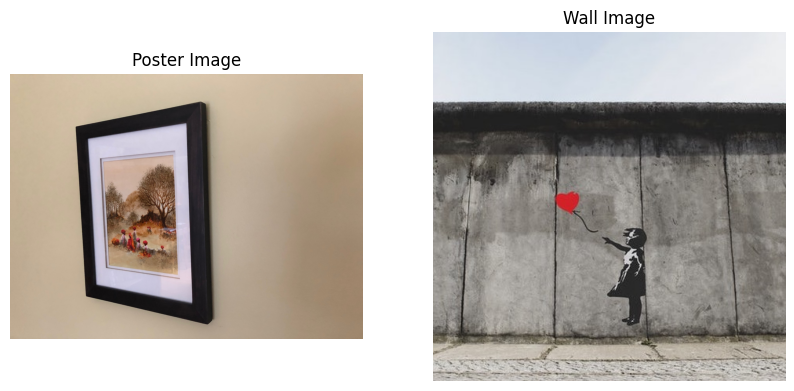

In [11]:
%matplotlib inline
homography = Homography()

print("Images for scene augementation exercise")
homography.get_images_scene_augmentation()

## Scene Augmentation using 4 points

Computed Homography =  [[ 6.08600926e-01  8.68441109e-02  5.33736469e+02]
 [-2.18571508e-01  1.36989804e+00  5.00252694e+02]
 [-2.97949227e-04  3.73618781e-05  1.00000000e+00]]

 Computed Homography by CV2 function =  (array([[ 6.08600866e-01,  8.68441026e-02,  5.33736452e+02],
       [-2.18571613e-01,  1.36989796e+00,  5.00252690e+02],
       [-2.97949411e-04,  3.73619186e-05,  1.00000000e+00]]), array([[1],
       [1],
       [1],
       [1]], dtype=uint8))

 Overlayed source image on the destimation image using 4 points for computing homography:


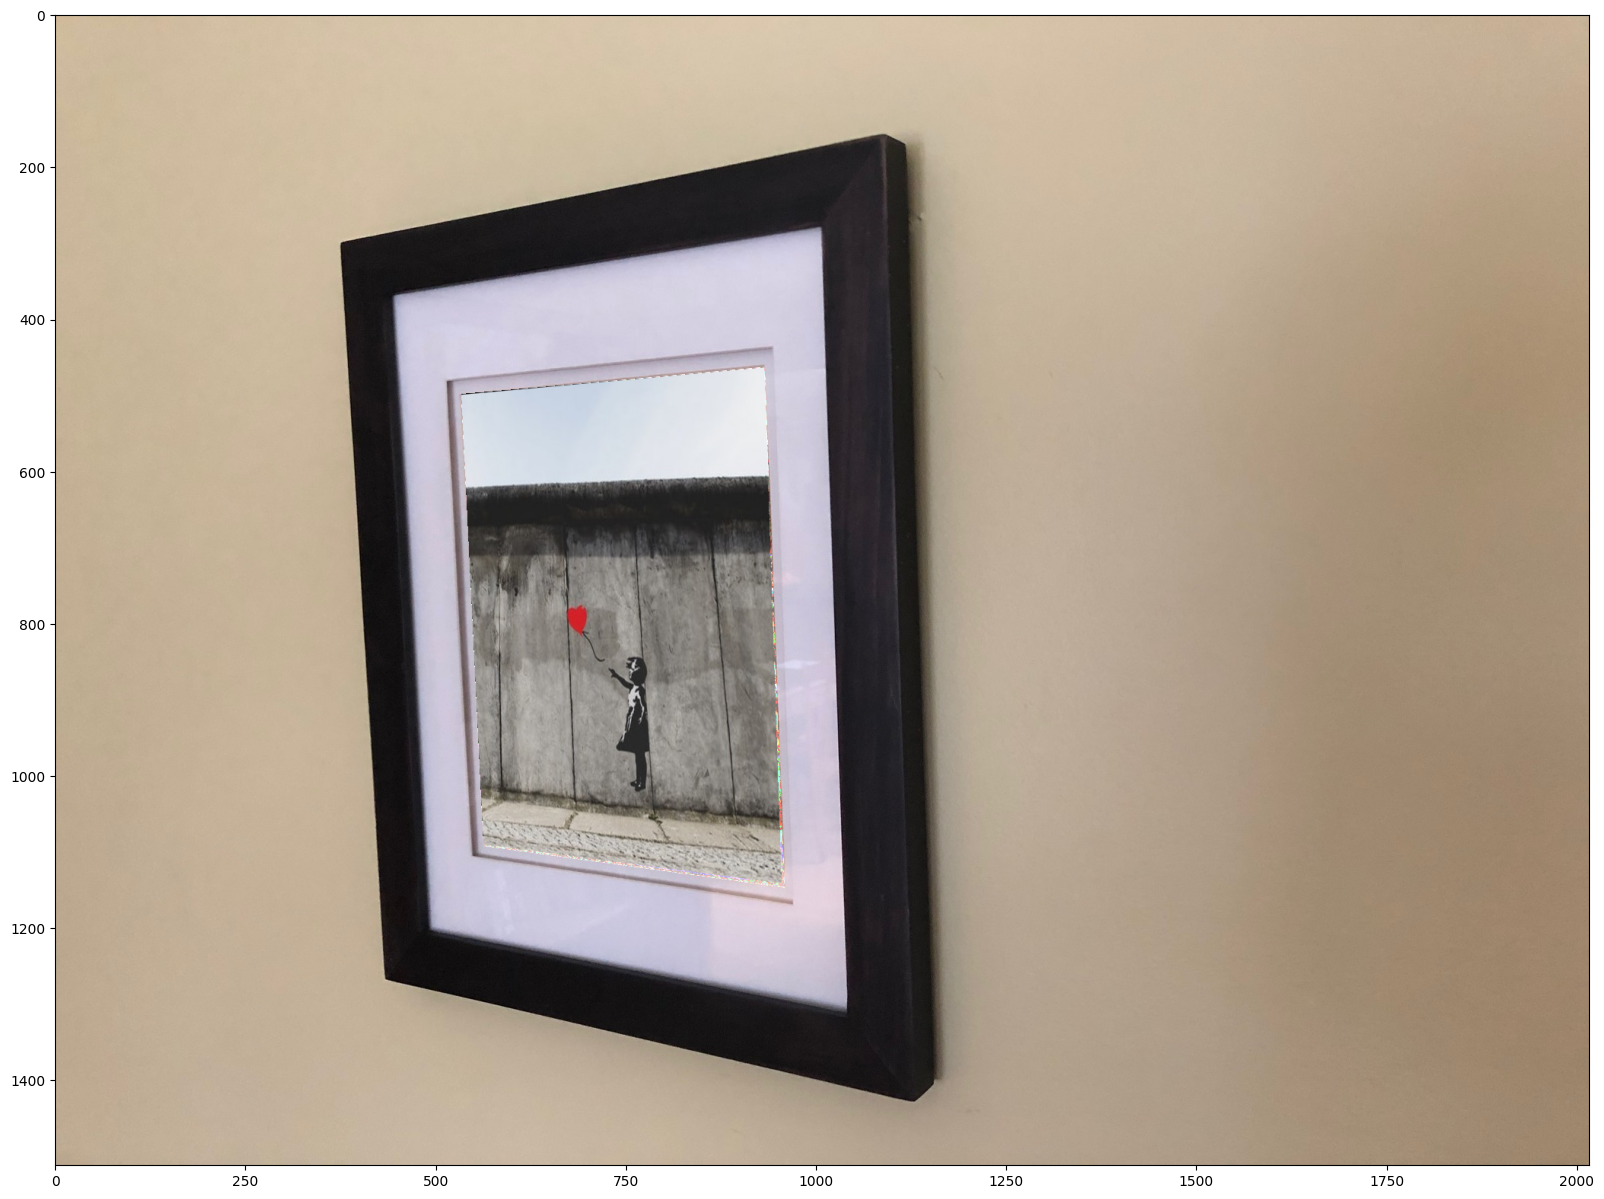

In [12]:
# Four points.
homography.get_points_for_scene_augmentation(4)
H = homography.compute_homography(homography.wall_points, homography.poster_points)
print("Computed Homography = ", H)


# Convert points to numpy arrays
poster_points = np.array(homography.poster_points, dtype='float32')
wall_points = np.array(homography.wall_points, dtype='float32')

# Convert to the shape required by cv2.findHomography
poster_points_for_cv2 = poster_points.reshape(-1, 1, 2)
wall_points_for_cv2 = wall_points.reshape(-1, 1, 2)

overlayed_image = homography.place_source_image_into_destination(homography.wall_image, homography.poster_image, poster_points_for_cv2, H)

H1 = cv2.findHomography(wall_points_for_cv2, poster_points_for_cv2)
print("\n Computed Homography by CV2 function = ", H1)

print("\n Overlayed source image on the destimation image using 4 points for computing homography:")

%matplotlib inline
plt.imshow(overlayed_image)
plt.show()

## Scene Augmentation using 8 Points

Computed Homography =  [[ 5.69965460e-01 -2.39709584e-02  5.40323233e+02]
 [-2.29458085e-01  1.17693818e+00  5.02717027e+02]
 [-2.93875122e-04 -1.24284023e-04  1.00000000e+00]]

 Computed Homography by CV2 function =  (array([[ 5.78174940e-01, -2.52694532e-02,  5.41006578e+02],
       [-2.23092360e-01,  1.18309583e+00,  5.02059155e+02],
       [-2.84657599e-04, -1.22121700e-04,  1.00000000e+00]]), array([[1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1]], dtype=uint8))

 Overlayed source image on the destimation image using 8 points for computing homography:


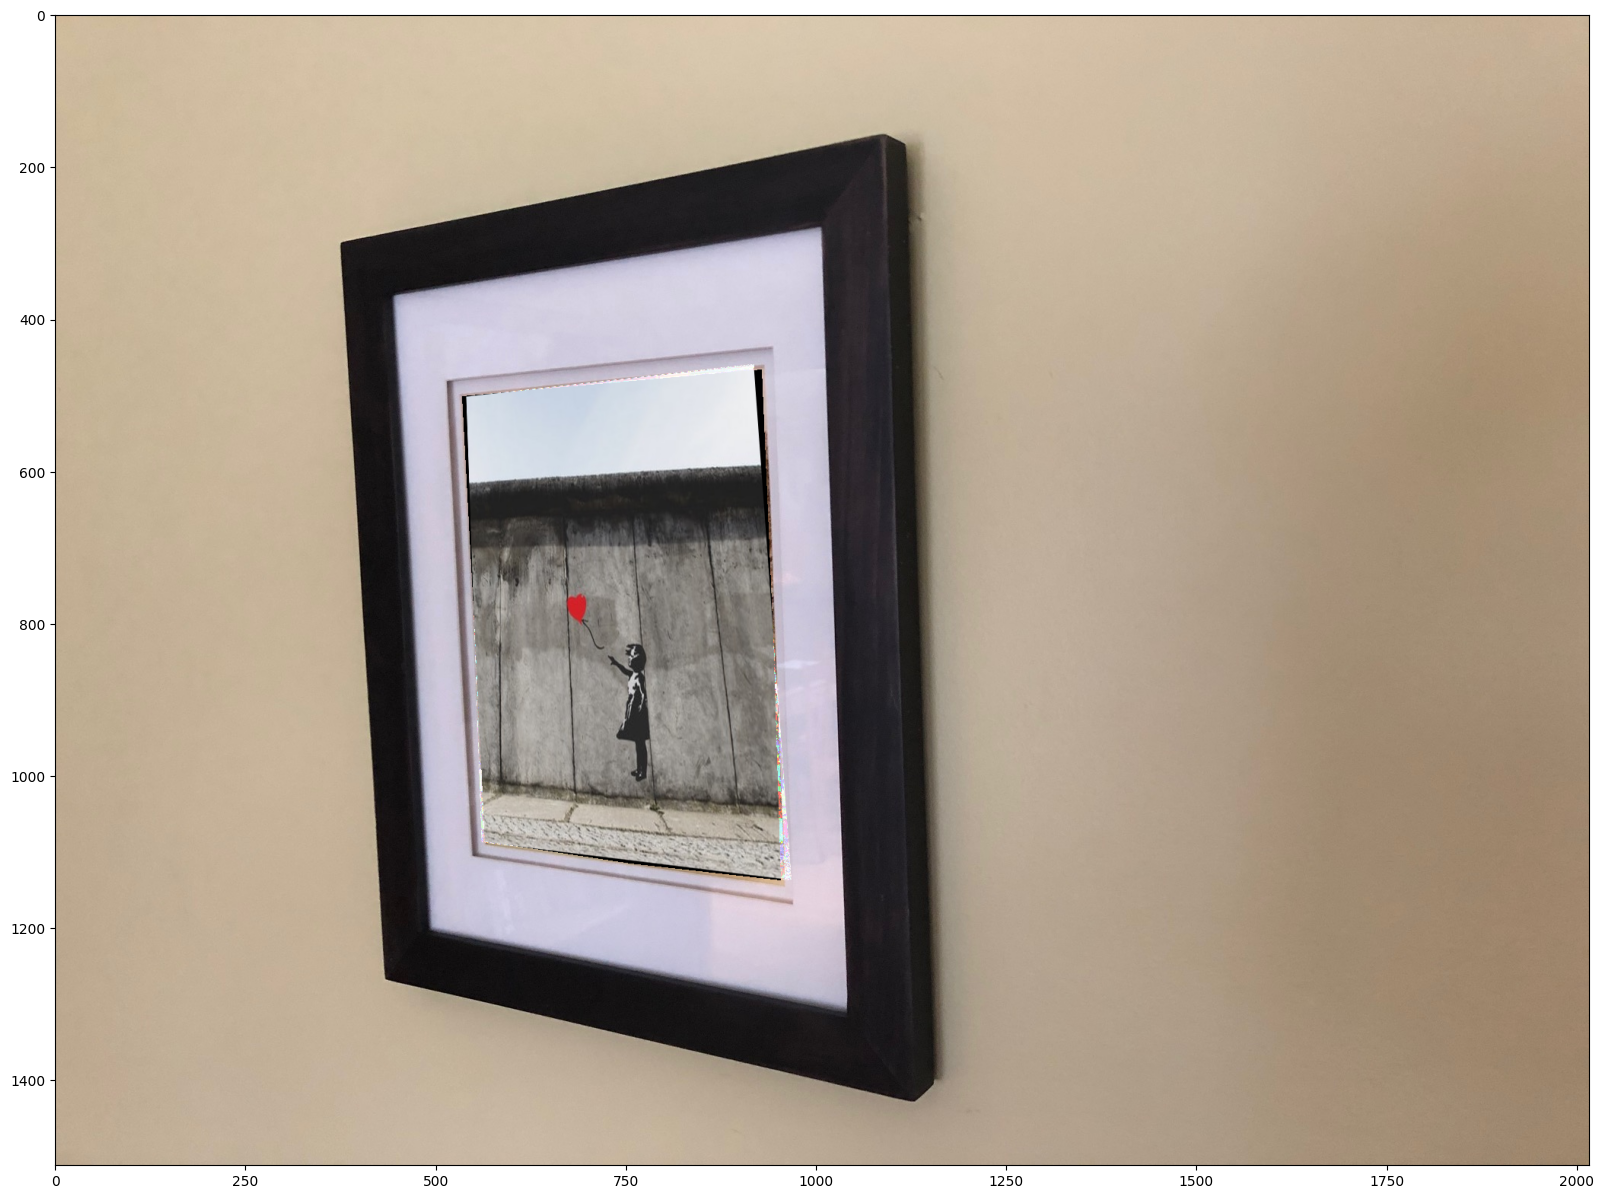


 Overlayed source image on the destimation image using 8 points for computing homography:


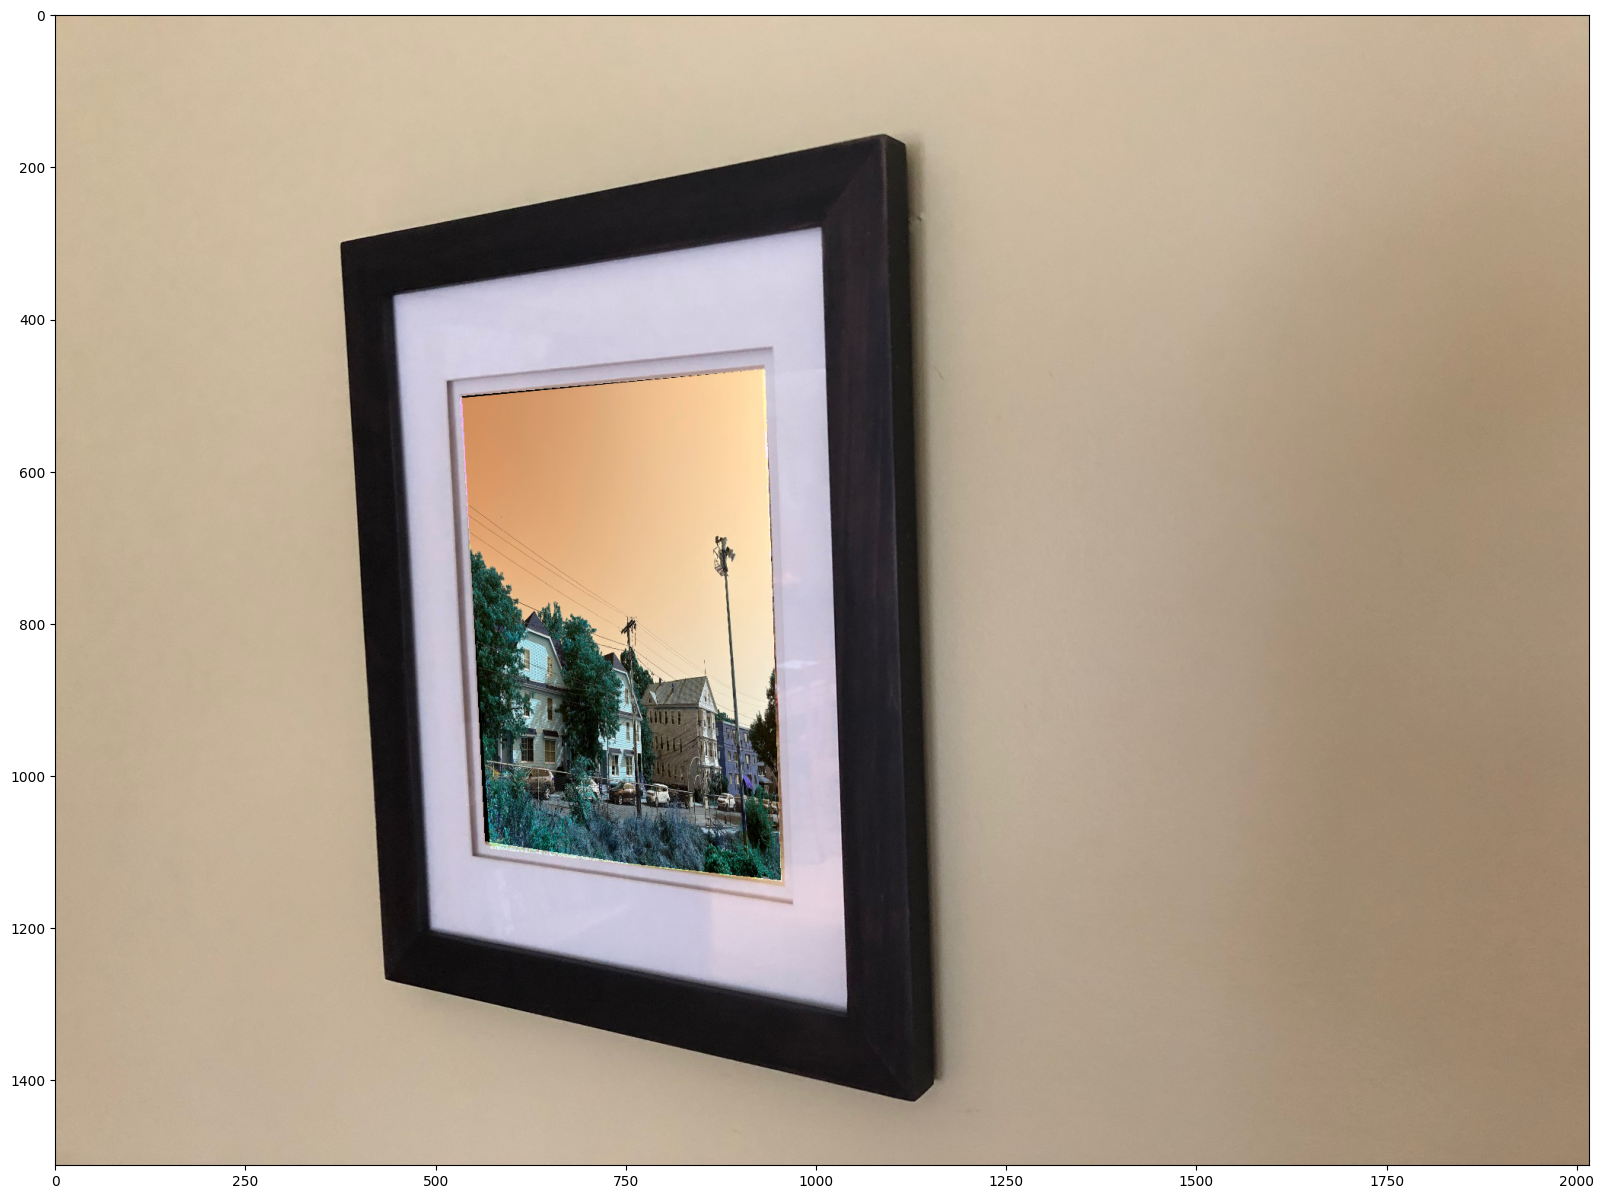

In [13]:
# Eight points.
homography.get_points_for_scene_augmentation(8)
H = homography.compute_homography(homography.wall_points, homography.poster_points)
print("Computed Homography = ", H)


# Convert points to numpy arrays
poster_points = np.array(homography.poster_points, dtype='float32')
wall_points = np.array(homography.wall_points, dtype='float32')

# Convert to the shape required by cv2.findHomography
poster_points_for_cv2 = poster_points.reshape(-1, 1, 2)
wall_points_for_cv2 = wall_points.reshape(-1, 1, 2)

overlayed_image = homography.place_source_image_into_destination(homography.wall_image, homography.poster_image, poster_points_for_cv2, H)

H1 = cv2.findHomography(wall_points_for_cv2, poster_points_for_cv2)
print("\n Computed Homography by CV2 function = ", H1)

print("\n Overlayed source image on the destimation image using 8 points for computing homography:")
%matplotlib inline
plt.imshow(overlayed_image)
plt.show()

# Try this on another image.
new_image = cv2.imread('ML_Playground1_1.jpeg')
mtplt.use('TkAgg')
# Click points on new image.
plt.imshow(new_image)
new_image_points = plt.ginput(8)
H_new_image = homography.compute_homography(new_image_points, homography.poster_points)
overlayed_new_image = homography.place_source_image_into_destination(new_image, homography.poster_image, poster_points_for_cv2, H_new_image)

# Plot
print("\n Overlayed source image on the destimation image using 8 points for computing homography:")
%matplotlib inline
plt.imshow(overlayed_new_image)
plt.show()


## Image Stitching : Panorama

### Get Images

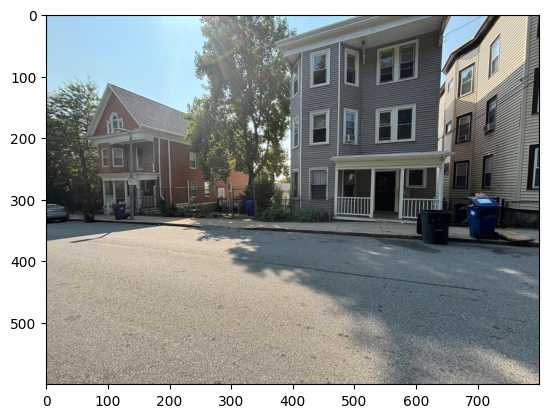

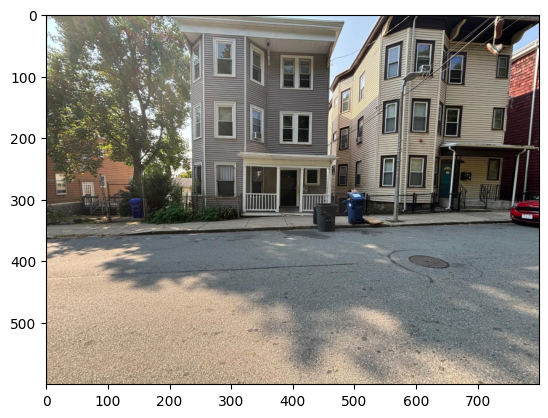

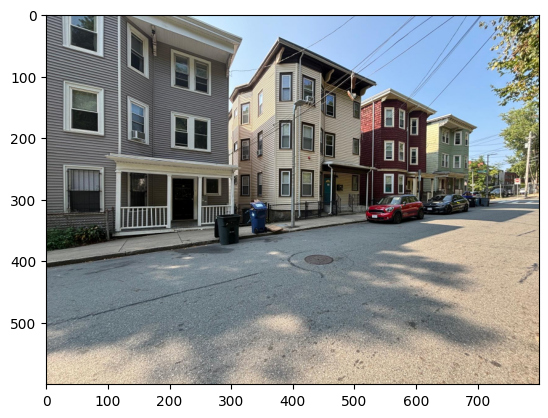

In [29]:
%matplotlib inline
homography = Homography()

homography.get_images_for_stitching(downsampling_factor=2)

### Manually pick overalapping points for image stitching

In [30]:
homography.get_points_for_image_stitching(num_points=4, use_file=True, filename="Fisher_Avenue_points.npy")

## Get Panorama and Plot

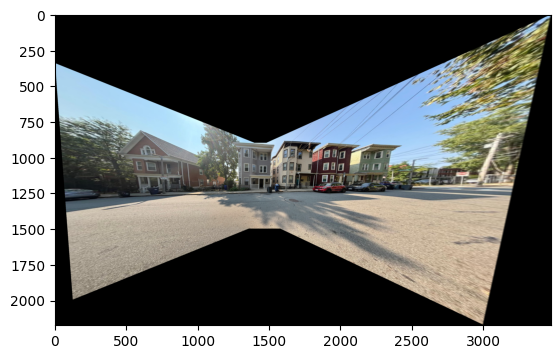

In [31]:
%matplotlib inline
homography.get_panorama()

## Difference of this approach of image mosiacing with "A Multiresolution Spline with Application to Image  Mosiacs" by Burt and Adelson

Paper: https://ai.stanford.edu/~kosecka/burt-adelson-spline83.pdf

The key challenge using homographies for image mosaicing is the appearance of seams at the intersections and necessitate some blending.

Burt and Adeslon propose to split both images into a set of band-pass components using Laplacian pyramids. So various versions of these images, from course to fine are blended separately. At the end, these band-pass mosiacs are merged together. The transition zones are narrow or broad for a feature depending on the wavelength of the feature.

The key difference here from the blending approach using `cv2.addWeighted` is that the latter is a **single resolution** blending that doesn't differentiate between fine details and broader low frequency details like skies. To get around this, I implemented a simple technique where the weight in the weighted addition is proportional to the distance of the pixel from the edges of either images. Thus if the pixel is deep within the image1 and close to image2 edges, the weighted addition at that mostly comprises of image1's brightness resulting is gradation. However, this method is merely a hack to get gradation and it results in smudging of details.

**Multi-resolution** spline image blending solves this by doing a different weighed addition at the same pixel in different bands, whereas the implemented approach considers a single weighted addition treating all frequencies equally.